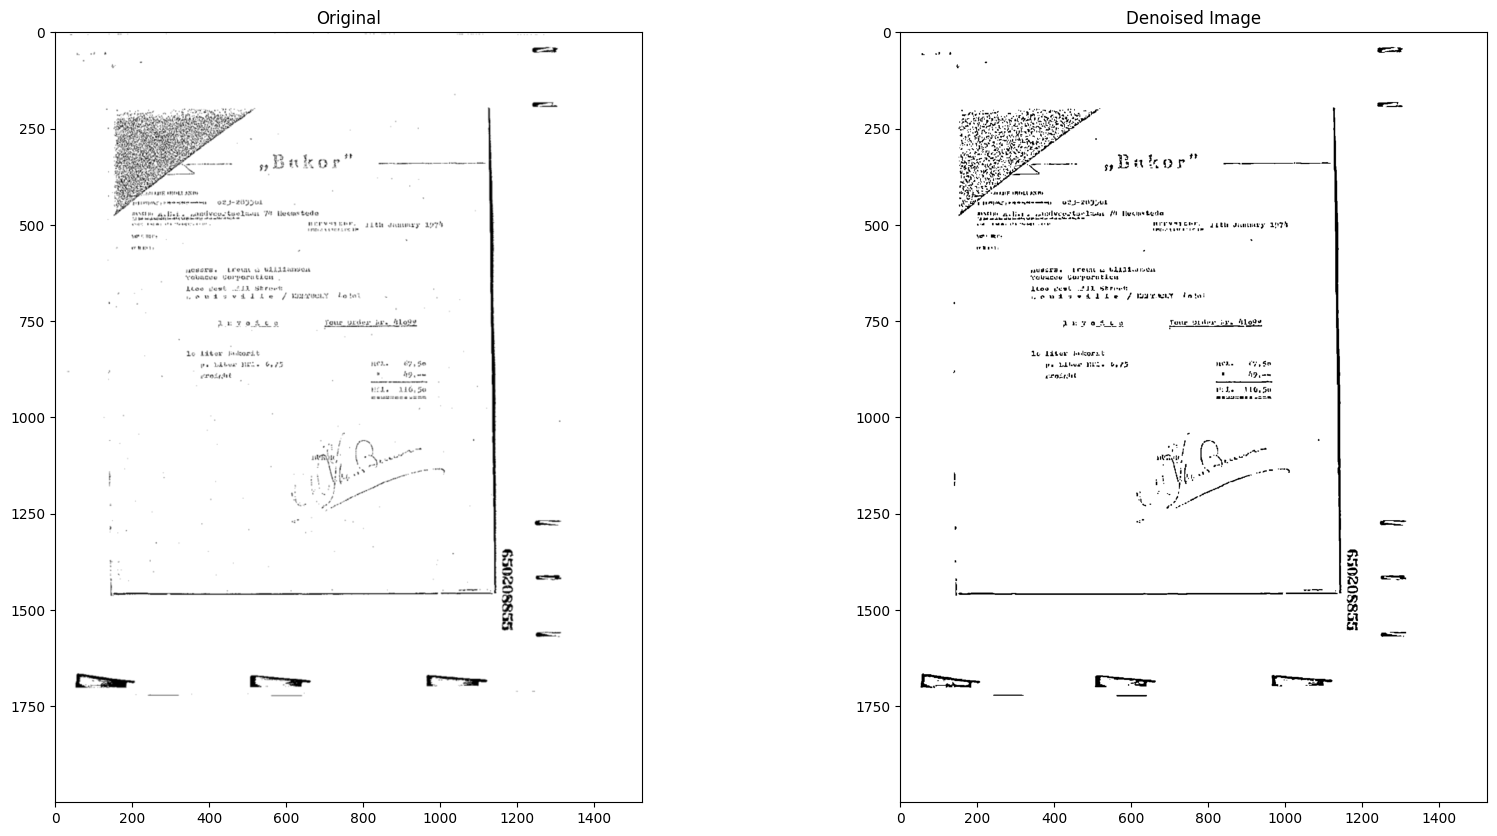

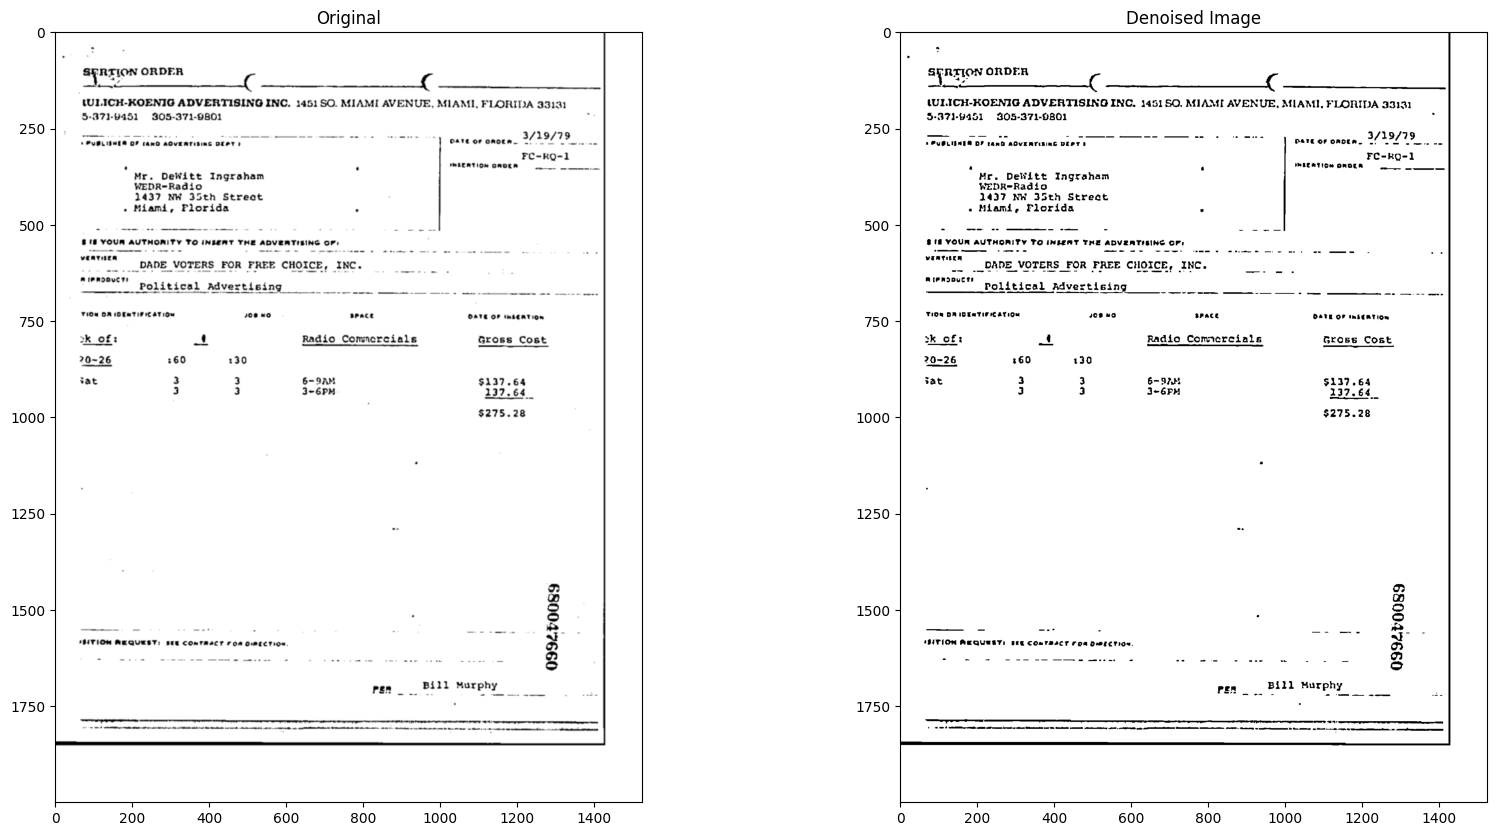

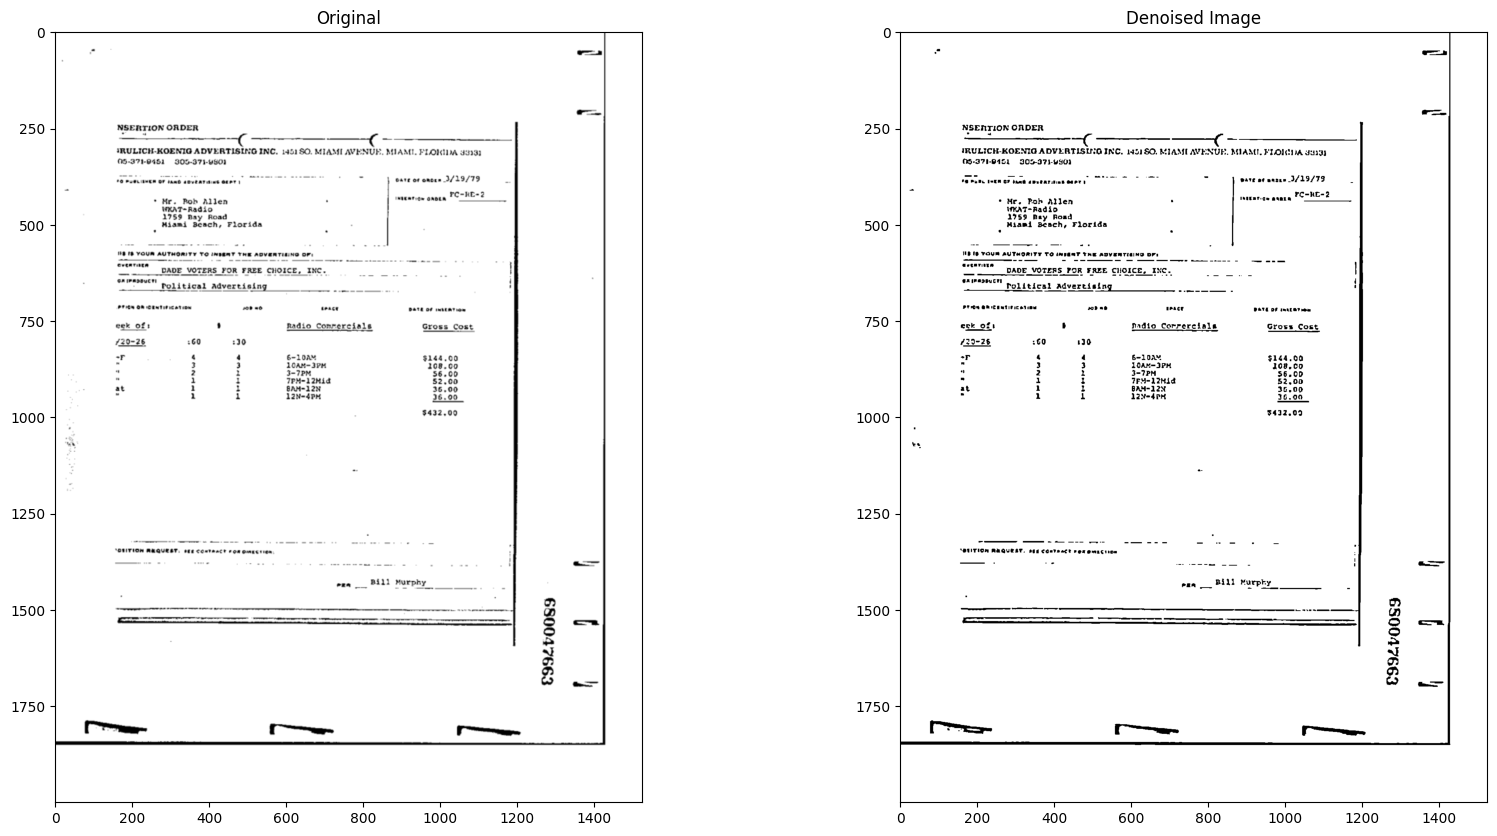

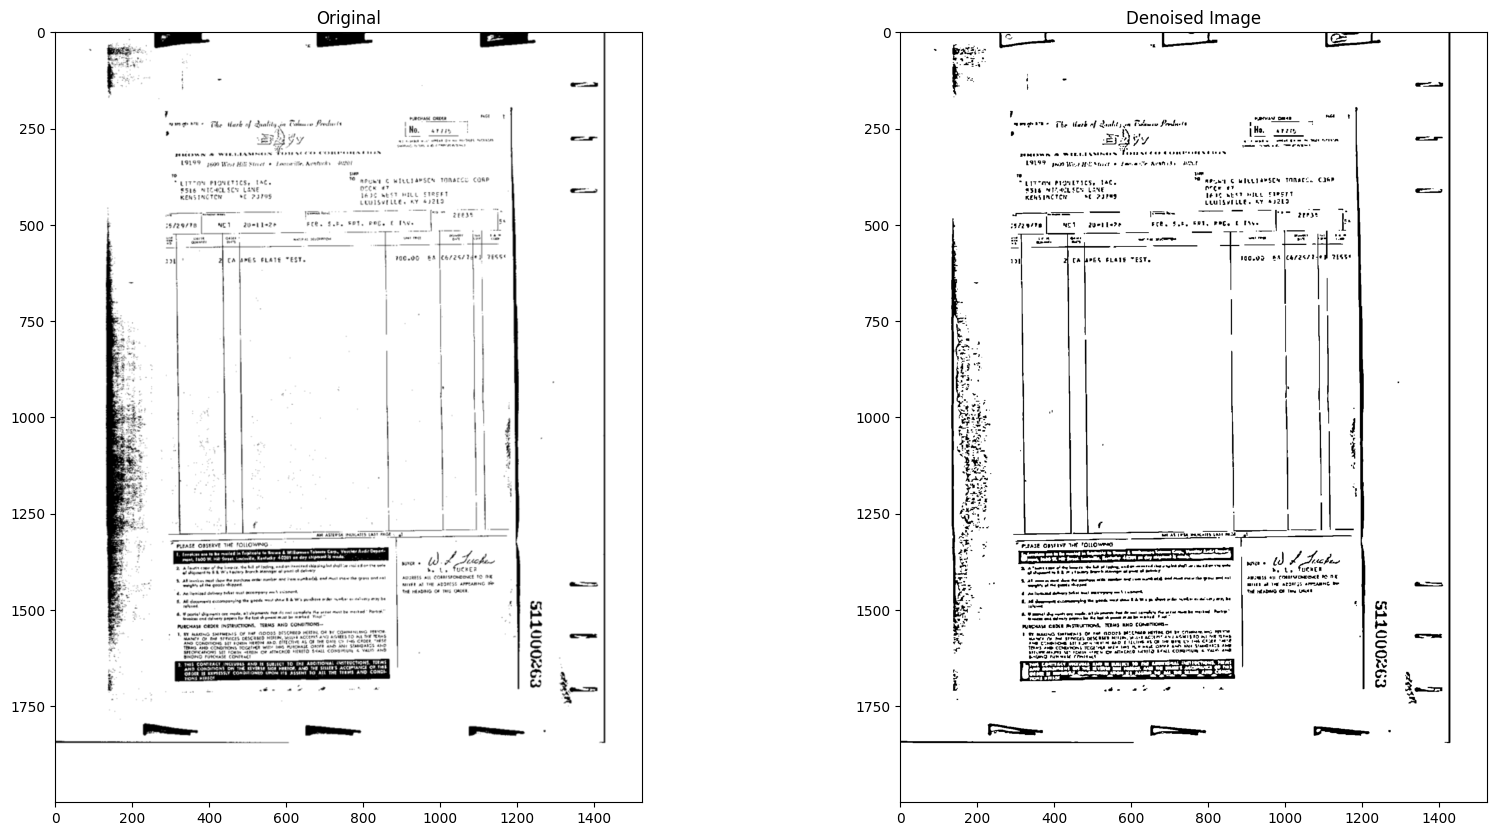

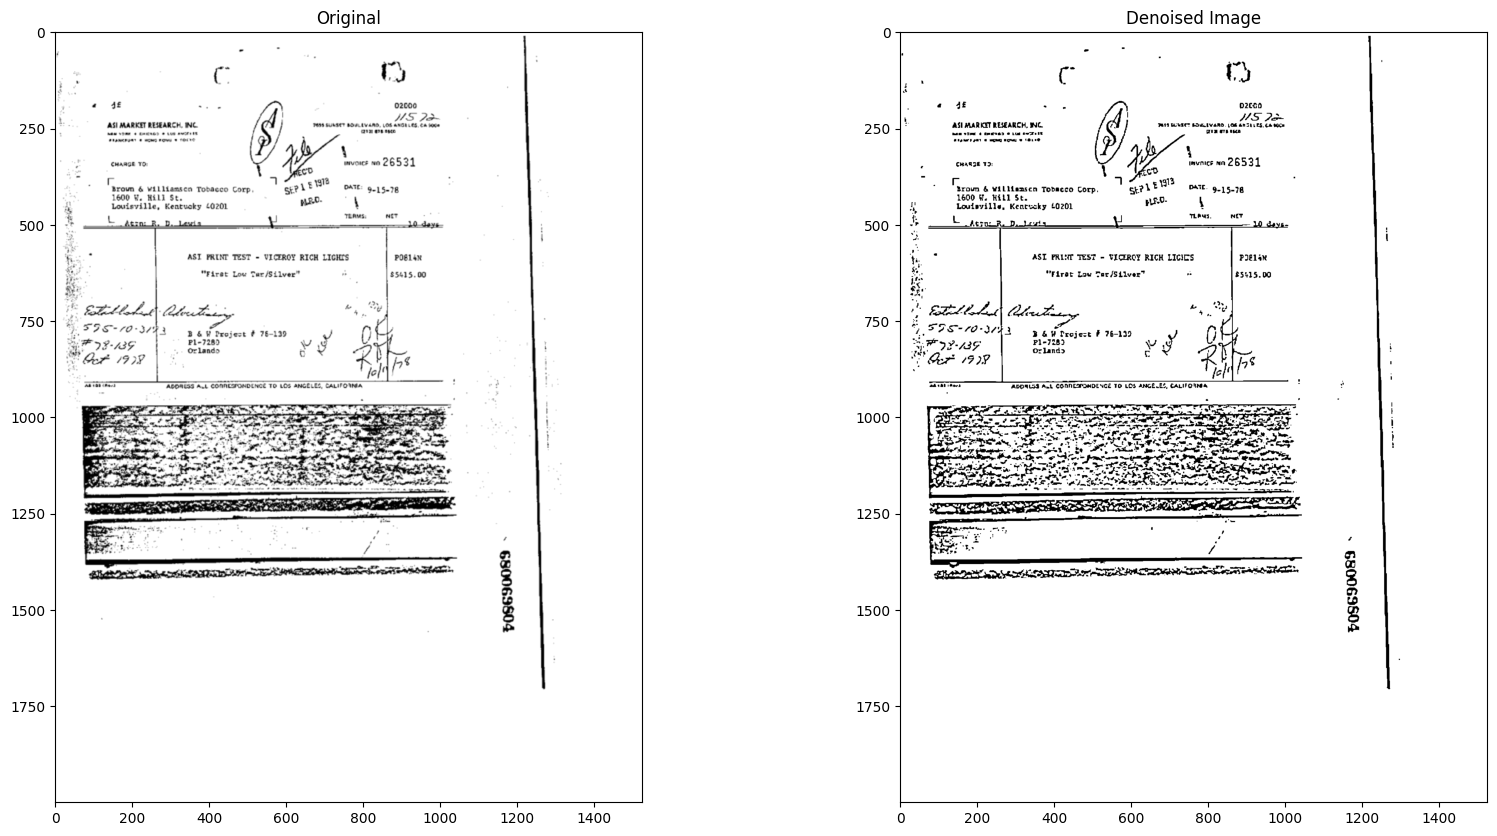

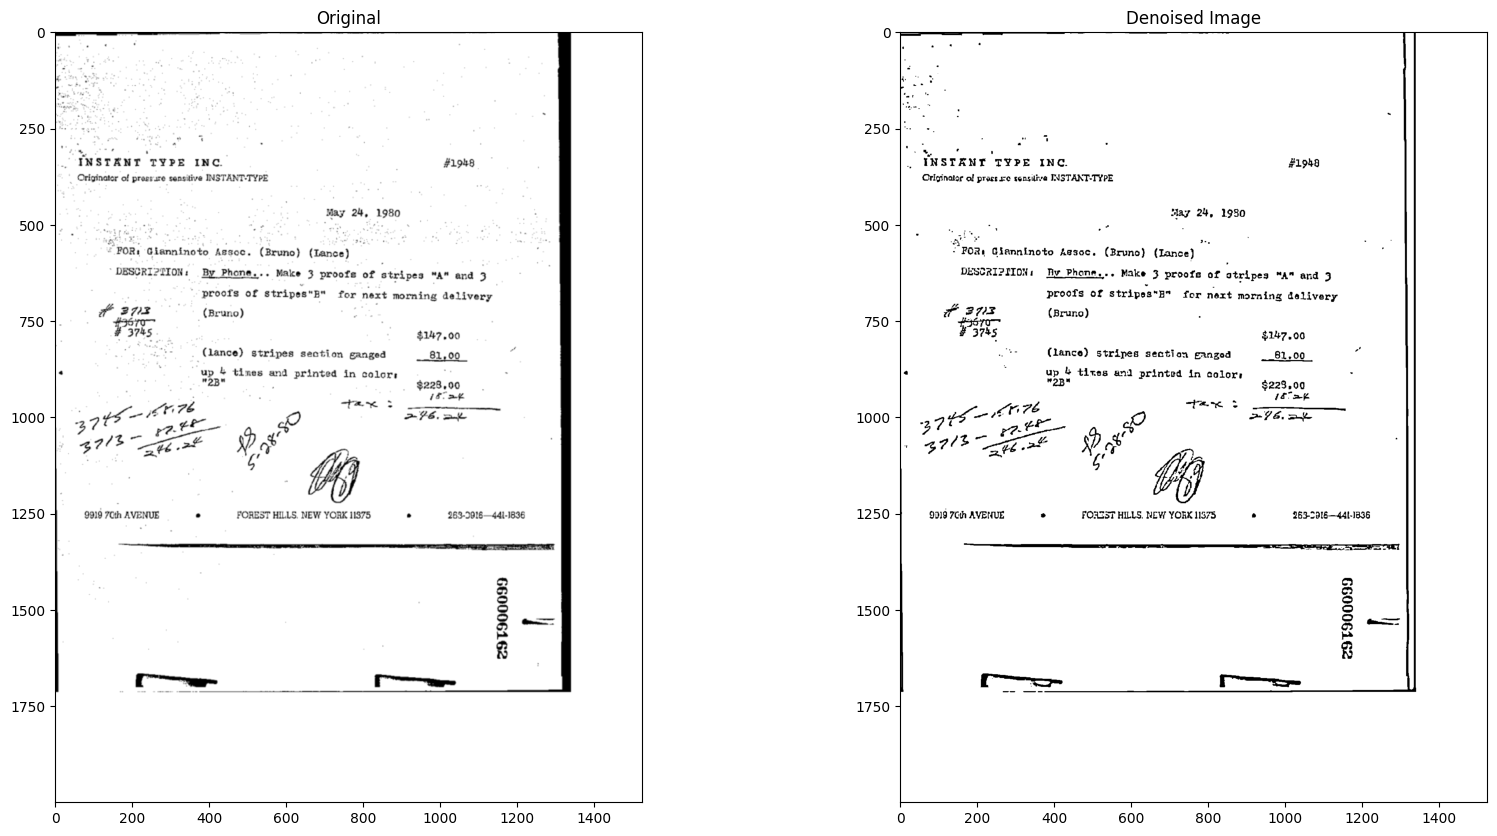

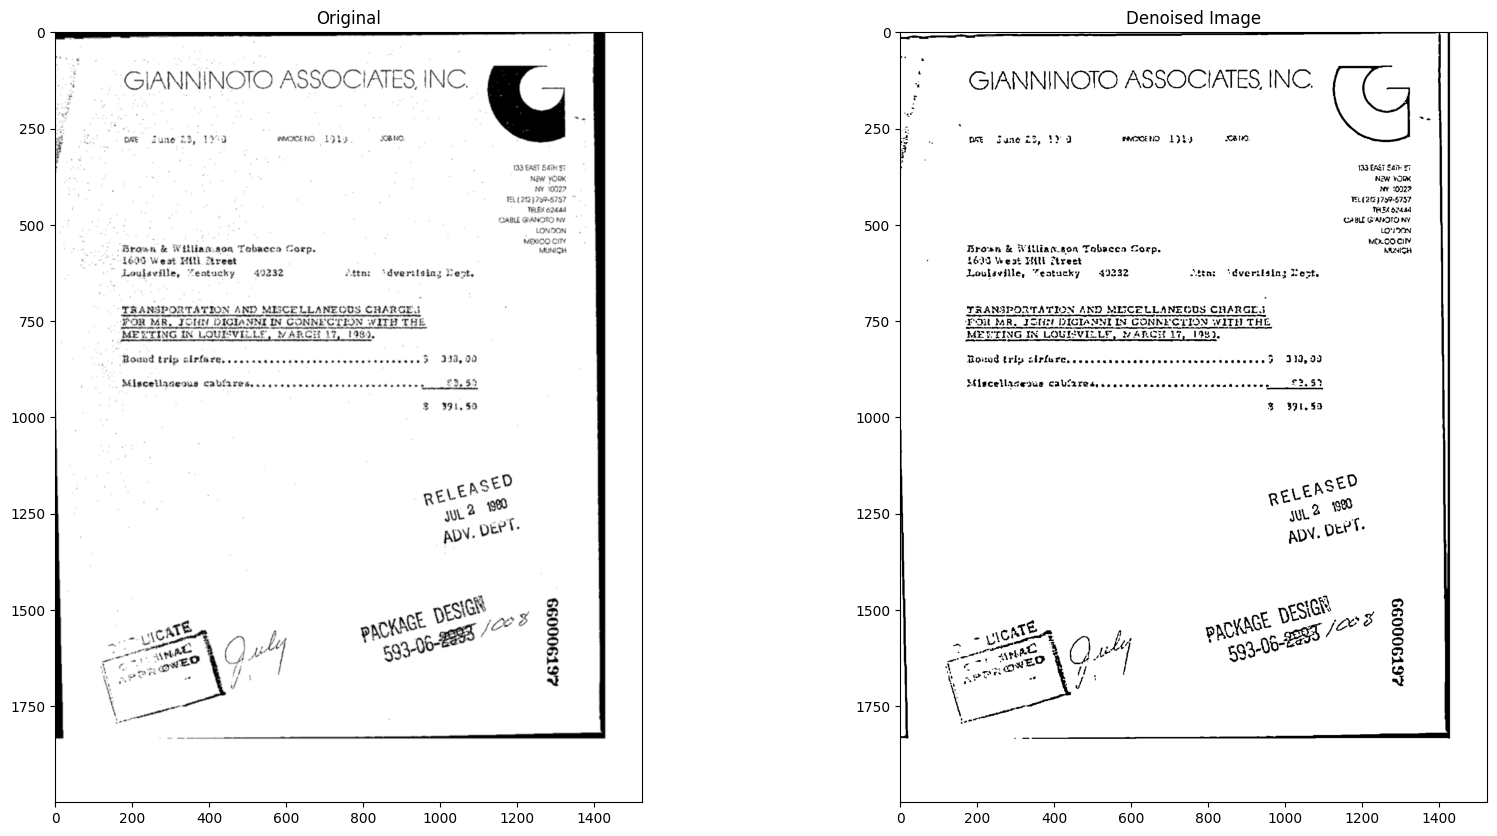

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def anisotropic_diffusion(image, iterations, kappa, gamma, option):
    image = image.astype('float32')

    if option == 1:
        image = cv2.GaussianBlur(image, (1, 1), 0)
    elif option == 2:
        image = cv2.medianBlur(image.astype(np.uint8), 3)

    # Pad the image to handle border cases
    image_padded = np.pad(image, ((1, 1), (1, 1)), mode='constant')

    for i in range(iterations):
        # Compute gradients
        nablaN = image_padded[:-2, 1:-1] - image_padded[1:-1, 1:-1]
        nablaS = image_padded[2:, 1:-1] - image_padded[1:-1, 1:-1]
        nablaW = image_padded[1:-1, :-2] - image_padded[1:-1, 1:-1]
        nablaE = image_padded[1:-1, 2:] - image_padded[1:-1, 1:-1]

        # Conductance
        cN = np.exp(-(nablaN / kappa) ** 2)
        cS = np.exp(-(nablaS / kappa) ** 2)
        cW = np.exp(-(nablaW / kappa) ** 2)
        cE = np.exp(-(nablaE / kappa) ** 2)

        # Update image
        image_update = image_padded[1:-1, 1:-1] + gamma * (
            cN * nablaN + cS * nablaS + cW * nablaW + cE * nablaE
        )

        # Update padded image
        image_padded[1:-1, 1:-1] = image_update

    return image_padded[1:-1, 1:-1]

def process_image(image_path, output_path):
    # Read the original image as grayscale
    org_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image for better OCR performance
    scale_factor = 2
    org_image = cv2.resize(org_image, (0, 0), fx=scale_factor, fy=scale_factor)

    # Apply Non-Local Means Denoising
    image = cv2.fastNlMeansDenoising(org_image, None, h=10, templateWindowSize=15, searchWindowSize=71)

    # Apply anisotropic diffusion
    denoised_image = anisotropic_diffusion(image, iterations=30, kappa=20, gamma=0.2, option=1)

    # Apply adaptive thresholding
    denoised_image = cv2.adaptiveThreshold(denoised_image.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 29)

    # Save the denoised image
    cv2.imwrite(output_path, denoised_image)

    # Display the original and denoised images
    plt.figure(figsize=(20, 10))  # Adjust width and height as desired
    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(org_image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Denoised Image')
    plt.imshow(denoised_image, cmap='gray')
    plt.show()


def main():
    dataset_directory = '/content/drive/MyDrive/Datasets/invoice (1)/invoice'

    # List all files in the directory
    files = sorted(os.listdir(dataset_directory))

    # Filter out non-image files
    files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))]

    # Process the first seven files
    for i, file in enumerate(files[:7]):
        image_path = os.path.join(dataset_directory, file)
        output_path = os.path.join(dataset_directory, f'denoised_enhanced_{i+1}.png')
        process_image(image_path, output_path)
if __name__ == "__main__":
    main()


**PCA **

In [ ]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca_denoising(image, variance_retained=0.95):
    # Convert image to float32 for PCA
    image_float32 = np.float32(image)

    # Flatten the image into a 1D array
    X = image_float32.flatten()

    # Perform PCA on the flattened image
    pca = PCA(n_components=variance_retained)
    pca.fit(X.reshape(-1, 1))

    # Project the noisy image onto the principal components
    projected_image = pca.transform(X.reshape(-1, 1))

    # Reconstruct the image using the reduced number of principal components
    reconstructed_image = pca.inverse_transform(projected_image).reshape(image.shape)

    # Convert reconstructed image back to uint8
    denoised_image = np.uint8(np.clip(reconstructed_image, 0, 255))

    return denoised_image

# Read the noisy text image
def process_image(image_path,output_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Step 1: Apply Gaussian Blurring
    blurred_image = cv2.GaussianBlur(image, (1, 1), 0)

    # Step 2: Apply PCA Denoising
    blurred_image = cv2.fastNlMeansDenoising(blurred_image, None, 10, 17, 60)
    variance_retained = 0.15
    pca_denoised_image = pca_denoising(blurred_image, variance_retained)

    # Step 3: Apply Non-Local Means Denoising
    #_, final_denoised_image = cv2.threshold(pca_denoised_image, 127, 255, cv2.THRESH_BINARY)
    final_denoised_image = cv2.adaptiveThreshold(pca_denoised_image.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 17)

    # Display the original and denoised images
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    '''plt.subplot(1, 3, 2)
    plt.imshow(pca_denoised_image, cmap='gray')
    plt.title('PCA Denoised Image')
    plt.axis('off')'''

    plt.subplot(1, 2, 2)
    plt.imshow(final_denoised_image, cmap='gray')
    plt.title('Final Denoised Image')
    plt.axis('off')

    cv2.imwrite(output_path,final_denoised_image)
def main():
    dataset_directory = '/content/drive/MyDrive/Datasets/invoice (1)/invoice'

    # List all files in the directory
    files = sorted(os.listdir(dataset_directory))

    # Filter out non-image files
    files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))]

    # Process the first seven files
    for i, file in enumerate(files[:7]):
        image_path = os.path.join(dataset_directory, file)
        output_path = os.path.join(dataset_directory, f'denoised_enhanced_{10+i}.png')
        process_image(image_path, output_path)
if __name__ == "__main__":
    main()


In [ ]:
# Bilateral filtering

import cv2
import matplotlib.pyplot as plt

def process_image(image_path,output_path):

    # Read the image
    org_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Bilateral Filtering

    image = cv2.fastNlMeansDenoising(org_image, None, h=10, templateWindowSize=7, searchWindowSize=41)
    denoised_image = cv2.bilateralFilter(image, d=15, sigmaColor=75, sigmaSpace=75)
    denoised_image = cv2.adaptiveThreshold(denoised_image.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 19)



    #_, denoised_image_bilateral = cv2.threshold(denoised_image_bilateral, 25, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    plt.figure(figsize=(20, 10))  # Adjust width and height as desired
    plt.subplot(1,2,1)
    plt.title('Original')
    plt.imshow(org_image,cmap='gray')

    plt.subplot(1,2,2)
    plt.title('Denoised_image')
    plt.imshow(denoised_image,cmap='gray')

    cv2.imwrite(output_path,denoised_image)
def main():
    dataset_directory = '/content/drive/MyDrive/Datasets/invoice (1)/invoice'

    # List all files in the directory
    files = sorted(os.listdir(dataset_directory))

    # Filter out non-image files
    files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))]

    # Process the first seven files
    for i, file in enumerate(files[:7]):
        image_path = os.path.join(dataset_directory, file)
        output_path = os.path.join(dataset_directory, f'denoised_enhanced_{1+i}.png')
        process_image(image_path, output_path)
if __name__ == "__main__":
    main()



In [ ]:
!pip install pytesseract

In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (6,128 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
!tesseract -v

tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


In [ ]:
!which tesseract

/usr/bin/tesseract


**Streamlit**

In [ ]:
import streamlit as st
from PIL import Image
import pytesseract
import numpy as np
from sklearn.decomposition import PCA
import cv2


background_color = "#F0F2F5"
st.markdown(f"""
<style>
    body {{
        background-color: {background_color};
    }}
</style>
""", unsafe_allow_html=True)


def denoise_approach_3(image):

    # Apply Bilateral Filtering
    image = cv2.fastNlMeansDenoising(image, None, h=10, templateWindowSize=7, searchWindowSize=41)
    denoised_image = cv2.bilateralFilter(image, d=15, sigmaColor=75, sigmaSpace=75)
    denoised_image = cv2.adaptiveThreshold(denoised_image.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 19)
    return denoised_image

def pca_denoising(image, variance_retained=0.95):
    # Convert image to float32 for PCA
    image_float32 = np.float32(image)

    # Flatten the image into a 1D array
    X = image_float32.flatten()

    # Perform PCA on the flattened image
    pca = PCA(n_components=variance_retained)
    pca.fit(X.reshape(-1, 1))

    # Project the noisy image onto the principal components
    projected_image = pca.transform(X.reshape(-1, 1))

    # Reconstruct the image using the reduced number of principal components
    reconstructed_image = pca.inverse_transform(projected_image).reshape(image.shape)

    # Convert reconstructed image back to uint8
    denoised_image = np.uint8(np.clip(reconstructed_image, 0, 255))

    return denoised_image

def denoise_approach_2(image):

    blurred_image = cv2.GaussianBlur(image, (1, 1), 0)

    # Step 2: Apply PCA Denoising
    blurred_image = cv2.fastNlMeansDenoising(blurred_image, None, 10, 17, 60)
    variance_retained = 0.15
    pca_denoised_image = pca_denoising(blurred_image, variance_retained)

    #_, final_denoised_image = cv2.threshold(pca_denoised_image, 127, 255, cv2.THRESH_BINARY)
    final_denoised_image = cv2.adaptiveThreshold(pca_denoised_image.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 17)
    return final_denoised_image

# Function to denoise image using Approach 1
def denoise_approach_1(image):
    scale_factor = 2
    org_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)

    # Apply Non-Local Means Denoising
    if len(org_image.shape) == 3 and org_image.shape[2] == 3:
      org_image = cv2.cvtColor(org_image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale if not already
    image = cv2.fastNlMeansDenoising(org_image, None, h=10, templateWindowSize=15, searchWindowSize=71)

    # Apply anisotropic diffusion
    denoised_image = anisotropic_diffusion(image, iterations=30, kappa=20, gamma=0.2, option=1)

    # Apply adaptive thresholding
    denoised_image = cv2.adaptiveThreshold(denoised_image.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 29)

    return denoised_image

def anisotropic_diffusion(image, iterations, kappa, gamma, option):
    image = image.astype('float32')

    if option == 1:
        image = cv2.GaussianBlur(image, (1, 1), 0)
    elif option == 2:
        image = cv2.medianBlur(image.astype(np.uint8), 3)

    # Pad the image to handle border cases
    image_padded = np.pad(image, ((1, 1), (1, 1)), mode='constant')

    for i in range(iterations):
        # Compute gradients
        nablaN = image_padded[:-2, 1:-1] - image_padded[1:-1, 1:-1]
        nablaS = image_padded[2:, 1:-1] - image_padded[1:-1, 1:-1]
        nablaW = image_padded[1:-1, :-2] - image_padded[1:-1, 1:-1]
        nablaE = image_padded[1:-1, 2:] - image_padded[1:-1, 1:-1]

        # Conductance
        cN = np.exp(-(nablaN / kappa) ** 2)
        cS = np.exp(-(nablaS / kappa) ** 2)
        cW = np.exp(-(nablaW / kappa) ** 2)
        cE = np.exp(-(nablaE / kappa) ** 2)

        # Update image
        image_update = image_padded[1:-1, 1:-1] + gamma * (
            cN * nablaN + cS * nablaS + cW * nablaW + cE * nablaE
        )

        # Update padded image
        image_padded[1:-1, 1:-1] = image_update

    return image_padded[1:-1, 1:-1]


def extract_text_from_image(image):
    return pytesseract.image_to_string(image, lang='eng',config=r'--oem 3 --psm 6')

# Main function to run the Streamlit app
def main():
    st.title("Image Denoising App")
    st.write("Upload your noisy image and choose the best denoising approach.")

    # Upload image
    uploaded_image = st.file_uploader("Upload", type=["jpg", "png", "jpeg", "tif"], accept_multiple_files=False)

    if uploaded_image is not None:
        # Display uploaded image
        image = Image.open(uploaded_image)
        original_height = 200
        denoised_height = 400
        image_np = np.array(image)

        # Calculate the aspect ratio
        aspect_ratio = image_np.shape[1] / image_np.shape[0]

        # Calculate the widths for the new heights
        original_width = int(original_height * aspect_ratio)
        denoised_width = int(denoised_height * aspect_ratio)
        st.image(image, caption='Uploaded Image', use_column_width=True,width=original_width)

        # Apply denoising approaches
        denoised_image_1 = denoise_approach_1(image_np)
        denoised_image_2 = denoise_approach_2(image_np)
        denoised_image_3 = denoise_approach_3(image_np)

        col1, col2, col3 = st.columns([5,5,5])
        with col1:
            st.image(denoised_image_1, caption='Anisotropic Diffusion', use_column_width=True, clamp=True, channels="GRAY", width=denoised_width)
            if st.button('Anisotropic OCR'):
                extracted_text = extract_text_from_image(denoised_image_1)
                st.text_area('Extracted Text', extracted_text, height=500)

        with col2:
            st.image(denoised_image_2, caption='PCA ', use_column_width=True, clamp=True, channels="GRAY", width=denoised_width)
            if st.button('PCA OCR'):
                extracted_text = extract_text_from_image(denoised_image_2)
                st.text_area('Extracted Text', extracted_text, height=500)

        with col3:
            st.image(denoised_image_3, caption='Bilateral Filtering', use_column_width=True, clamp=True, channels="GRAY", width=denoised_width)
            if st.button('Bilateral Filtering OCR'):
                extracted_text = extract_text_from_image(denoised_image_3)
                st.text_area('Extracted Text', extracted_text, height=500)
# Run the app
if __name__ == '__main__':
    main()


2024-05-29 07:23:08.624 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]


Vertical

In [ ]:
import streamlit as st
from PIL import Image
import pytesseract
import numpy as np
from sklearn.decomposition import PCA
import cv2


'''custom_css = """
<style>
body {
    background-color: #f8f9fa; /* Set background color */
    font-family: Arial, sans-serif; /* Set font */
}
h1 {
    color: #333333; /* Set title color */
    text-align: center; /* Center-align title */
}
</style>
"""
# Apply custom CSS
st.markdown(custom_css, unsafe_allow_html=True)'''


def denoise_approach_3(image):

    # Apply Bilateral Filtering
    image = cv2.fastNlMeansDenoising(image, None, h=10, templateWindowSize=7, searchWindowSize=41)
    denoised_image = cv2.bilateralFilter(image, d=15, sigmaColor=75, sigmaSpace=75)
    denoised_image = cv2.adaptiveThreshold(denoised_image.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 19)
    return denoised_image

def pca_denoising(image, variance_retained=0.95):
    # Convert image to float32 for PCA
    image_float32 = np.float32(image)

    # Flatten the image into a 1D array
    X = image_float32.flatten()

    # Perform PCA on the flattened image
    pca = PCA(n_components=variance_retained)
    pca.fit(X.reshape(-1, 1))

    # Project the noisy image onto the principal components
    projected_image = pca.transform(X.reshape(-1, 1))

    # Reconstruct the image using the reduced number of principal components
    reconstructed_image = pca.inverse_transform(projected_image).reshape(image.shape)

    # Convert reconstructed image back to uint8
    denoised_image = np.uint8(np.clip(reconstructed_image, 0, 255))

    return denoised_image

def denoise_approach_2(image):

    blurred_image = cv2.GaussianBlur(image, (1, 1), 0)

    # Step 2: Apply PCA Denoising
    blurred_image = cv2.fastNlMeansDenoising(blurred_image, None, 10, 17, 60)
    variance_retained = 0.15
    pca_denoised_image = pca_denoising(blurred_image, variance_retained)

    #_, final_denoised_image = cv2.threshold(pca_denoised_image, 127, 255, cv2.THRESH_BINARY)
    final_denoised_image = cv2.adaptiveThreshold(pca_denoised_image.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 17)
    return final_denoised_image

# Function to denoise image using Approach 1
def denoise_approach_1(image):
    scale_factor = 2
    org_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor)

    # Apply Non-Local Means Denoising
    if len(org_image.shape) == 3 and org_image.shape[2] == 3:
      org_image = cv2.cvtColor(org_image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale if not already
    image = cv2.fastNlMeansDenoising(org_image, None, h=10, templateWindowSize=15, searchWindowSize=71)

    # Apply anisotropic diffusion
    denoised_image = anisotropic_diffusion(image, iterations=30, kappa=20, gamma=0.2, option=1)

    # Apply adaptive thresholding
    denoised_image = cv2.adaptiveThreshold(denoised_image.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 29)

    return denoised_image

def anisotropic_diffusion(image, iterations, kappa, gamma, option):
    image = image.astype('float32')

    if option == 1:
        image = cv2.GaussianBlur(image, (1, 1), 0)
    elif option == 2:
        image = cv2.medianBlur(image.astype(np.uint8), 3)

    # Pad the image to handle border cases
    image_padded = np.pad(image, ((1, 1), (1, 1)), mode='constant')

    for i in range(iterations):
        # Compute gradients
        nablaN = image_padded[:-2, 1:-1] - image_padded[1:-1, 1:-1]
        nablaS = image_padded[2:, 1:-1] - image_padded[1:-1, 1:-1]
        nablaW = image_padded[1:-1, :-2] - image_padded[1:-1, 1:-1]
        nablaE = image_padded[1:-1, 2:] - image_padded[1:-1, 1:-1]

        # Conductance
        cN = np.exp(-(nablaN / kappa) ** 2)
        cS = np.exp(-(nablaS / kappa) ** 2)
        cW = np.exp(-(nablaW / kappa) ** 2)
        cE = np.exp(-(nablaE / kappa) ** 2)

        # Update image
        image_update = image_padded[1:-1, 1:-1] + gamma * (
            cN * nablaN + cS * nablaS + cW * nablaW + cE * nablaE
        )

        # Update padded image
        image_padded[1:-1, 1:-1] = image_update

    return image_padded[1:-1, 1:-1]


def extract_text_from_image(image):
    return pytesseract.image_to_string(image, lang='eng')

# Main function to run the Streamlit app
def main():
    st.title("Image Denoising App")
    st.write("Upload your noisy image and choose the best denoising approach.")

    # Upload image
    uploaded_image = st.file_uploader("Upload", type=["jpg", "png", "jpeg", "tif"], accept_multiple_files=False)

    if uploaded_image is not None:
        # Display uploaded image
        image = Image.open(uploaded_image)
        original_height = 200
        denoised_height = 400
        image_np = np.array(image)

        # Calculate the aspect ratio
        aspect_ratio = image_np.shape[1] / image_np.shape[0]

        # Calculate the widths for the new heights
        original_width = int(original_height * aspect_ratio)
        denoised_width = int(denoised_height * aspect_ratio)
        #st.image(image, caption='Uploaded Image', use_column_width=True,width=original_width)

        # Apply denoising approaches
        denoised_image_1 = denoise_approach_1(image_np)
        denoised_image_2 = denoise_approach_2(image_np)
        denoised_image_3 = denoise_approach_3(image_np)

        col1, col2 = st.columns([8, 2])  # Adjust the values to set the width ratios

        with col1:
            st.image(image, caption='Uploaded Image', use_column_width=True)

        with col2:

            # Apply denoising approaches
            denoised_image_1 = denoise_approach_1(image_np)
            denoised_image_2 = denoise_approach_2(image_np)
            denoised_image_3 = denoise_approach_3(image_np)

            # Display denoised images and extract text buttons

            st.image(denoised_image_1, caption='Anisotropic Diffusion', use_column_width=True, clamp=True, channels="GRAY")

            if st.button('Extract Text (Anisotropic Diffusion)'):
                extracted_text = extract_text_from_image(denoised_image_1)
                st.text_area('Extracted Text (Anisotropic Diffusion)', extracted_text, height=200)


            st.image(denoised_image_2, caption='PCA', use_column_width=True, clamp=True, channels="GRAY")

            if st.button('Extract Text (PCA)'):
                extracted_text = extract_text_from_image(denoised_image_2)
                st.text_area('Extracted Text (PCA)', extracted_text, height=200)


            st.image(denoised_image_3, caption='Bilateral Filtering', use_column_width=True, clamp=True, channels="GRAY")

            if st.button('Extract Text (Bilateral Filtering)'):
                extracted_text = extract_text_from_image(denoised_image_3)
                st.text_area('Extracted Text (Bilateral Filtering)', extracted_text, height=200)


# Run the app
if __name__ == '__main__':
    main()


In [ ]:
! pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00


In [ ]:
!wget -q -O - ipv4.icanhazip.com

35.230.67.32


In [ ]:
! streamlit run aniso.py & npx localtunnel --port 8501




npx: installed 22 in 4.607s
your url is: https://beige-facts-enter.loca.lt

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.230.67.32:8501

